## Lab 3: Circuit Analysis in a Convolutional Neural Network

Team: Mike Wisniewski, Henry Lambson, Alex Gregory

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import requests

from io import BytesIO
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

In [3]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

In [4]:
def load_image_as_array(url, size=(224, 224)):
    # response = requests.get(url)
    # img = Image.open(BytesIO(response.content))
    img = Image.open(url)
    img = img.resize(size)
    return np.array(img).astype(float)

In [5]:
def generate_pattern(layer_name, filter_index, size=224):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the aoutput 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(ITERATIONS):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            loss = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(loss, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return img

In [6]:
def grad_cam(img, class_idx=None):
    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    # this is A_{i,j,k} (in keras tensor form) above
    Aijk_as_kt = model.get_layer(LAYER_NAME).output
    # make new model with access to various layers of interest
    new_model = models.Model(inputs=model.input, 
                             outputs=[Aijk_as_kt, model.output])

    # create a variable with the image data
    I = np.expand_dims(img, axis=0)

    # now use gradient tape to get the gradients (watching only the variable v)
    with tf.GradientTape(watch_accessed_variables=True) as tape:
        Aijk_as_tf, fc_as_tf = new_model(I) # get outputs
        
        if class_idx == None:
            # just get maximum class, if not set by user
            class_idx = np.argmax(fc_as_tf)
            
        sum_fc = tf.reduce_mean(fc_as_tf[:, class_idx]) # define what we want to maximize

    # This is the gradient of the predicted class with regard to
    # the output feature map of `block5_conv3`
    # this is the df / dA above
    grad_fc_wrt_Aijk_as_tf = tape.gradient(sum_fc, Aijk_as_tf) # get gradients that influence loss w.r.t. last conv


    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    # this is the alpha values in tensor form
    alpha_k_as_tf = tf.reduce_mean(grad_fc_wrt_Aijk_as_tf, 
                                   axis=(0, 1, 2))
    #                              axis=(Batch x I x J)


    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    # these are the numpy outputs for alpha_k and A_{i,j,k}
    alpha_k = alpha_k_as_tf.numpy() # now in numpy form
    A = Aijk_as_tf.numpy() # also get the last layer as numpy


    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the predicted class
    # this is alpha*A before it is collapsed with the mean
    for i in range(256):
        A[:, :, :, i] *= alpha_k[i]
        # only highlight positive influences for class
        A[:, :, :, i] = np.maximum(A[:, :, :, i], 0)

        # B x I x J x Chan

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    # this is our S_{i,j} above (before normalizing)
    S = np.sum(A, axis=-1)
    # size of S is now Batch x I x J (summed over channels)

    # We then normalize the heatmap 0-1 for visualization:
    # this is where we account for S_max
    S /= np.max(S)
    return S

In [7]:
def grad_cam_single_filter(img, class_idx=None):
    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    # this is A_{i,j,k} (in keras tensor form) above
    Aijk_as_kt = model.get_layer(LAYER_NAME).output
    # make new model with access to various layers of interest
    new_model = models.Model(inputs=model.input, 
                             outputs=Aijk_as_kt)

    # create a variable with the image data
    I = np.expand_dims(img, axis=0)

    I = tf.Variable(I, name='image_var', dtype = 'float64')
    I = preprocess_input(I)

    # now use gradient tape to get the gradients (watching only the variable v)
    with tf.GradientTape(watch_accessed_variables=True) as tape:
        tape.watch(I)
        Aijk_as_tf = new_model(I) # get outputs
        loss = tf.reduce_mean(Aijk_as_tf[:, :, :, FILTER_INDEX])

    # This is the gradient of the predicted class with regard to
    # the output feature map of `block5_conv3`
    # this is the df / dA above
    grad_fc_wrt_Aijk_as_tf = tape.gradient(loss, Aijk_as_tf) # get gradients that influence loss w.r.t. last conv


    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    # this is the alpha values in tensor form
    alpha_k_as_tf = tf.reduce_mean(grad_fc_wrt_Aijk_as_tf, 
                                   axis=(0, 1, 2))
    #                              axis=(Batch x I x J)


    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    # these are the numpy outputs for alpha_k and A_{i,j,k}
    alpha_k = alpha_k_as_tf.numpy() # now in numpy form
    A = Aijk_as_tf.numpy() # also get the last layer as numpy


    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the predicted class
    # this is alpha*A before it is collapsed with the mean
    # A[:, :, :, FILTER_INDEX] *= alpha_k[FILTER_INDEX]
    # # only highlight positive influences for class
    # A[:, :, :, FILTER_INDEX] = np.maximum(A[:, :, :, FILTER_INDEX], 0)

    for i in range(256):
        A[:, :, :, i] *= alpha_k[i]
        # only highlight positive influences for class
        A[:, :, :, i] = np.maximum(A[:, :, :, i], 0)

        # B x I x J x Chan

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    # this is our S_{i,j} above (before normalizing)
    S = np.sum(A, axis=-1)
    # size of S is now Batch x I x J (summed over channels)

    # We then normalize the heatmap 0-1 for visualization:
    # this is where we account for S_max
    S /= np.max(S)
    return S

In [25]:
LAYER_NAME = "block3_conv3"
FILTER_INDEX = 12
IMAGE_LENGTH = 224
IMAGE_WIDTH = 224
ITERATIONS = 100
IMG_PATH = ['images/finch.jpeg', 'images/pepper.jpeg', 'images/printer.jpeg', 'images/bus.jpeg', 'images/tricycle.jpeg']
EXTENT = (0, IMAGE_LENGTH, 0, IMAGE_WIDTH)

>[3 Points] In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) https://keras.io/api/applications/
>
>   - It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.  
>   - Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.

test images from imagenet: https://www.kaggle.com/datasets/lijiyu/imagenet

In [26]:
# Load the pre-trained VGG16 model
model = VGG19(weights='imagenet', include_top=True, input_tensor=None)

# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

(1, 224, 224, 3)
Predicted: [('n01531178', 'goldfinch', 0.9999168), ('n01530575', 'brambling', 2.5116155e-05), ('n01560419', 'bulbul', 1.327918e-05)]


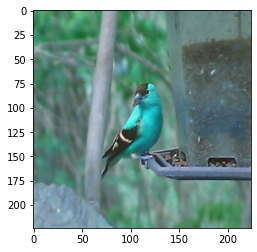

(1, 224, 224, 3)
Predicted: [('n07720875', 'bell_pepper', 0.9940262), ('n03461385', 'grocery_store', 0.005014434), ('n07718472', 'cucumber', 0.0006438933)]


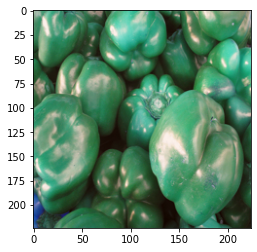

(1, 224, 224, 3)
Predicted: [('n03924679', 'photocopier', 0.981736), ('n04004767', 'printer', 0.018126782), ('n04554684', 'washer', 0.00011148219)]


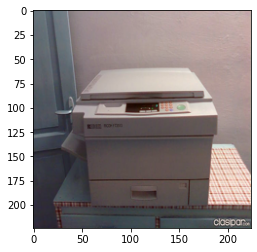

(1, 224, 224, 3)
Predicted: [('n04146614', 'school_bus', 0.8263196), ('n04252225', 'snowplow', 0.15606457), ('n03417042', 'garbage_truck', 0.0043642344)]


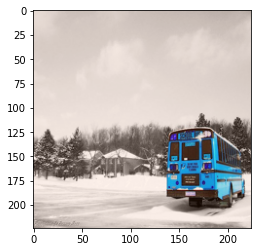

(1, 224, 224, 3)
Predicted: [('n04482393', 'tricycle', 0.9033628), ('n03444034', 'go-kart', 0.049837194), ('n03649909', 'lawn_mower', 0.024878431)]


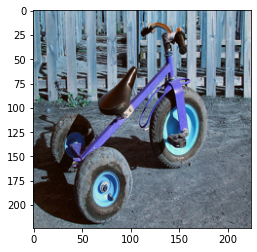

In [27]:
# load in an image
for image in IMG_PATH:

    img = load_image_as_array(image, size=(IMAGE_LENGTH, IMAGE_WIDTH))

    # create image tensor and preprocess image for prediction
    img_tensor = np.expand_dims(img, axis=0)
    img_tensor = preprocess_input(img_tensor)

    preds = model.predict(img_tensor)

    # plot impage
    print(img_tensor.shape)
    print('Predicted:', decode_predictions(preds, top=3)[0])
    plt.imshow(prepare_image_for_display(img_tensor))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


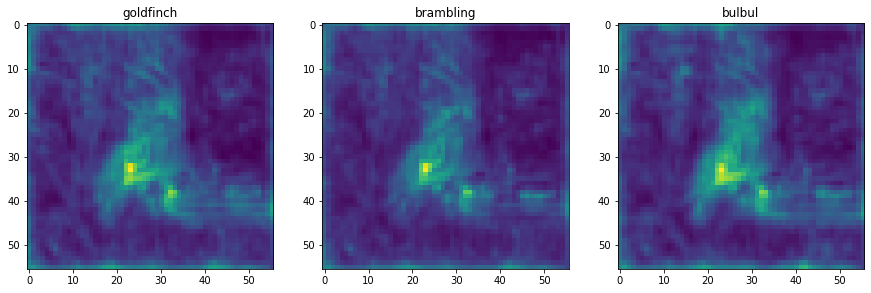

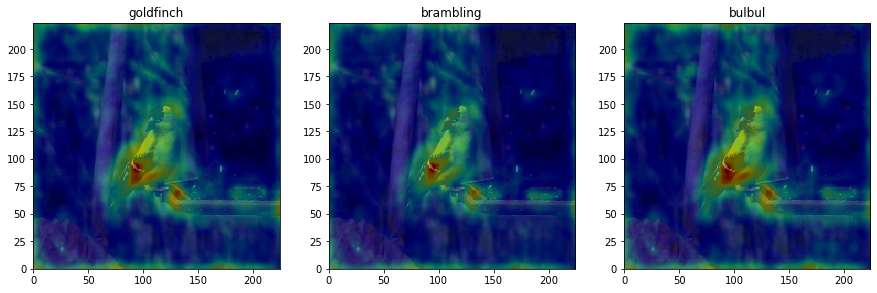

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


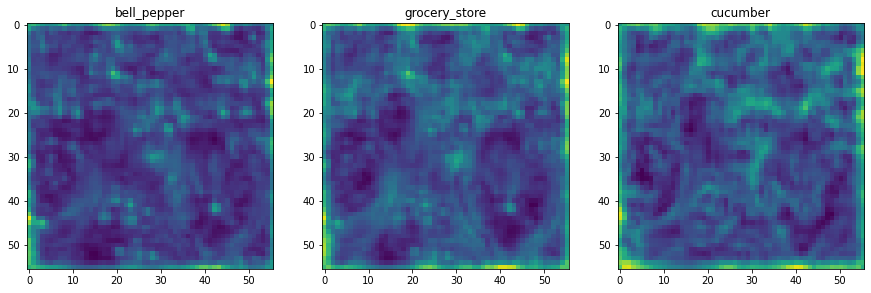

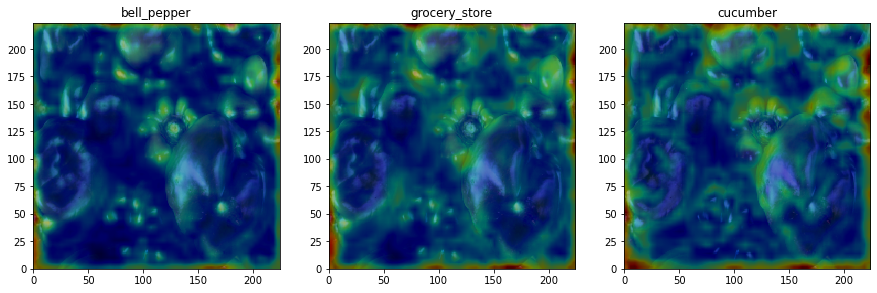

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


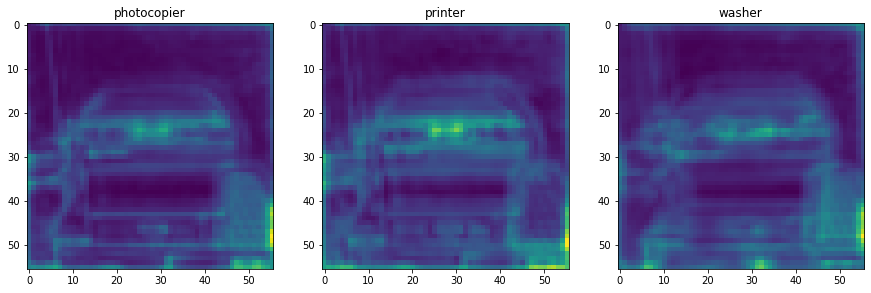

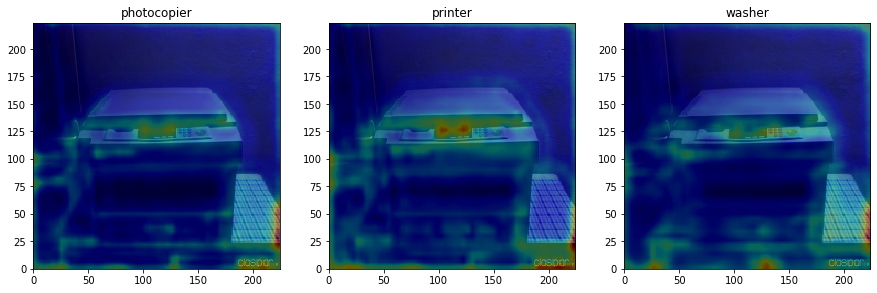

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


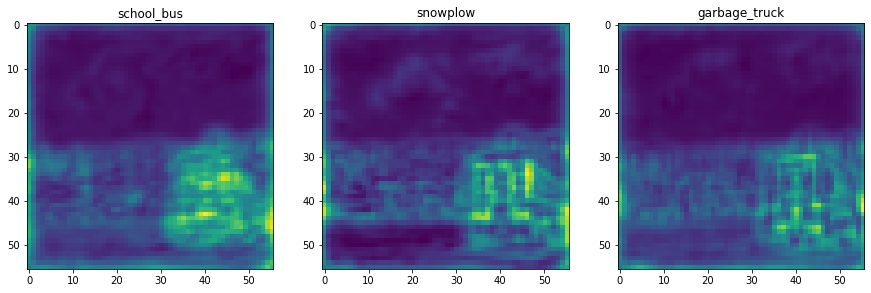

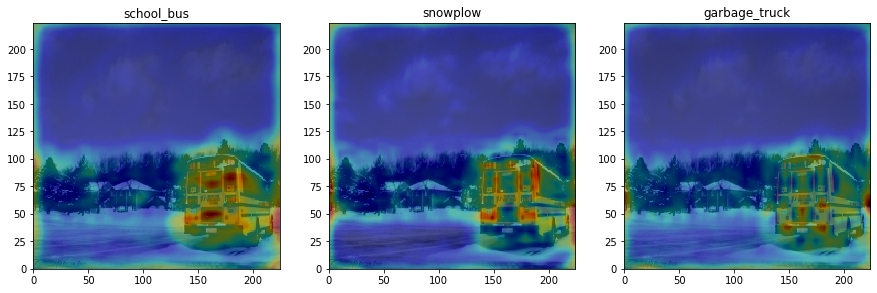

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


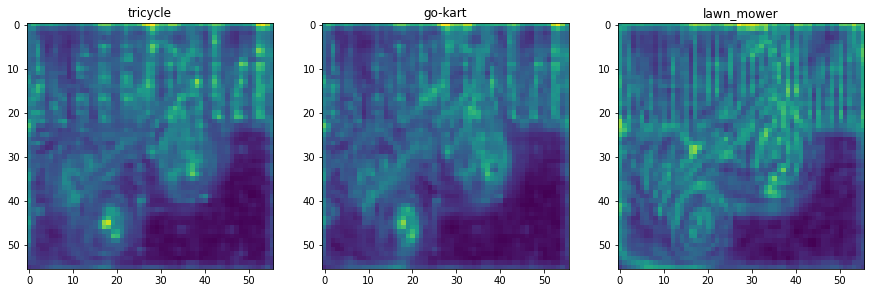

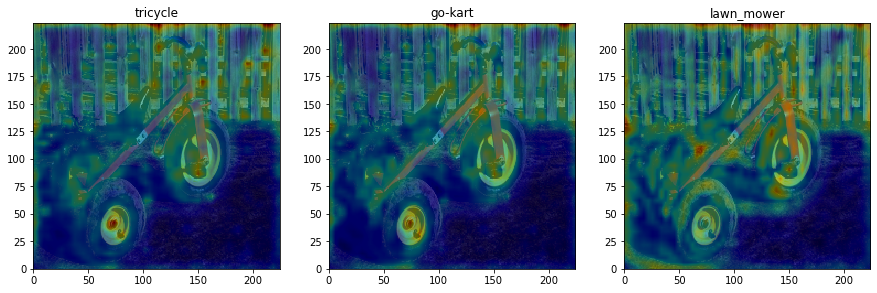

In [28]:
# iterate through each image and visually identify photos that the model predicts well
for image in IMG_PATH:

    # load in image
    img = load_image_as_array(image, size=(IMAGE_LENGTH, IMAGE_WIDTH))

    # create image tensor and preprocess image for prediction
    img_tensor = np.expand_dims(img, axis=0)
    img_tensor = preprocess_input(img_tensor)

    # predict image
    preds = model.predict(img_tensor)
    
    # extract labels
    labels = [label[1] for label in decode_predictions(preds, top=3)[0]]

    # getting a list of predicted classes
    predicted_class = np.argmax(preds)

    # extract top 3 indices
    preds = np.squeeze(preds)
    topk_idx = np.argsort(preds)[-3:]

    # get class areas for each of top k predictions
    all_S = [grad_cam(img, class_idx=idx) for idx in topk_idx]

    # show each heatmap
    plt.figure(figsize=(15,5))
    for i,idx in enumerate(topk_idx):    
        plt.subplot(1,3,i+1)
        plt.imshow(np.squeeze(all_S[i]))
        plt.title(labels[i])
        
    # show overlay of each heatmap
    plt.figure(figsize=(15,5),frameon=False)
    for i,idx in enumerate(topk_idx):    
        plt.subplot(1,3,i+1)
        
        plt.imshow(img/255, interpolation='nearest', extent=EXTENT)
        # use jet here for color mapping, even though I hate jet
        plt.imshow(np.squeeze(all_S[i]), cmap=plt.cm.jet, alpha=0.4,
                interpolation='bilinear',
                extent=EXTENT)
        
        plt.title(labels[i])
        
    plt.show()

Our group elected to use VGG19 as our pretrained model to investigate. We felt that VGG19 would be a good model to look at because of its high layer count. Since we want to investigate filters in the middle of a model, we felt that a model with more layers would be a good example. VGG19 is strong at classifying simple objects, so it would be easy to find images for us to test on the filters. VGG19 is included in OpenAI's microscope, so we are able to easily verify if the patterns we create for the filters are accurate. We chose to look into the "block3_conv3" layer because it is right in the middle of the model. From this layer, we chose a random filter to investigate, filter 12.

As shown in the example images passed through the model, VGG19 is able to accurately classify each of the pictures with confidences ranging from aproximately 82% to almost 100%. The model is clearly functioning correctly. To get an idea of what the model is looking for when it classifies an image, we plotted what the model was activated most by in each image in heatmaps. 

>[4 Points] Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit. This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are a few convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/
>
>   - Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class: https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynb 
>   - Also send images of varying class (i.e. from ImageNet) through the network and track which classes of images most excite your chosen filter. 
>   - Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network? 
>   - If using code from another source, you must heavily document the code so that I can grade your understanding of the code used. 

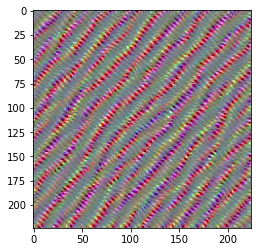

In [29]:
# for the 12th filter in block 3, conv 3 - what image excites this filter?
excited_image = generate_pattern(LAYER_NAME, FILTER_INDEX, size=IMAGE_LENGTH)
excited_image = prepare_image_for_display(excited_image, norm_type='std')
plt.imshow(excited_image)
plt.show()

Here is the input image that maximally excites filter 12 in block 3 convolution 3. Based on this image, we believe that this filter is trained to activate when it finds diagonal lines going upward from left to right. This image shares similarities to the images classified as lines in the Zoom In article (https://distill.pub/2020/circuits/zoom-in/), which led us to the hypothesis that this filter is looking for diagonal lines.

In [13]:
for layer_name in [LAYER_NAME]:
    
    NUM_CHANNELS = 3
    NUM_FILTERS = 256
    HEIGHT = int(NUM_FILTERS**(1/2))
    WIDTH = int(HEIGHT - 1)
    margin = 5
    size = IMAGE_LENGTH

    # This a empty (black) image where we will store our results.
    results = np.zeros((HEIGHT * size + WIDTH * margin, HEIGHT * size + WIDTH * margin, NUM_CHANNELS)).astype('uint8')

    for i in range(HEIGHT):  # iterate over the rows of our results grid
        for j in range(HEIGHT):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * HEIGHT), size=size)
            filter_img = prepare_image_for_display(filter_img, norm_type='std')

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(40, 40))
    plt.imshow(results)
    plt.title(layer_name)
    plt.show()

KeyboardInterrupt: 

In [30]:
FILTER_INDEX = 12

['goldfinch', 'brambling', 'bulbul']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


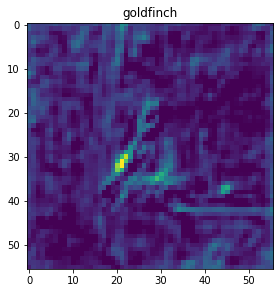

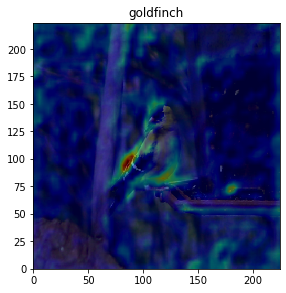

['bell_pepper', 'grocery_store', 'cucumber']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


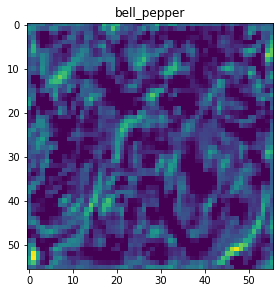

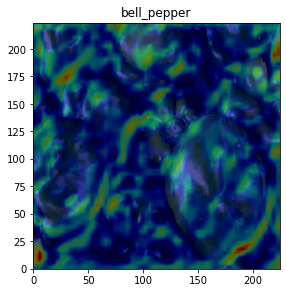

['photocopier', 'printer', 'washer']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


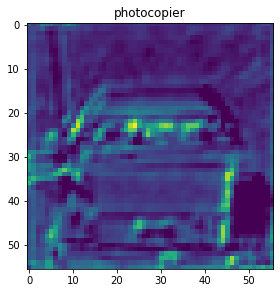

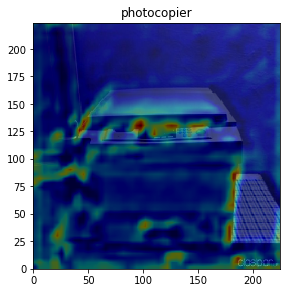

['school_bus', 'snowplow', 'garbage_truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


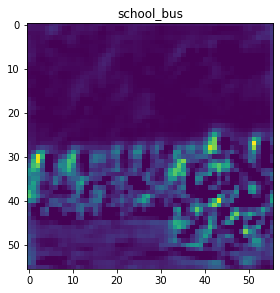

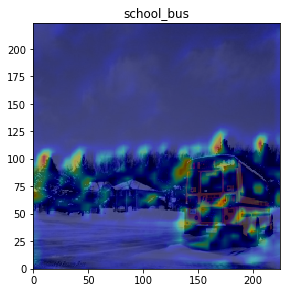

['tricycle', 'go-kart', 'lawn_mower']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


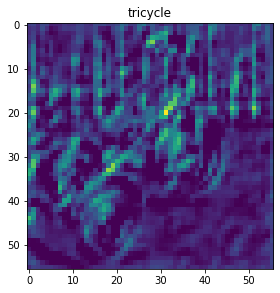

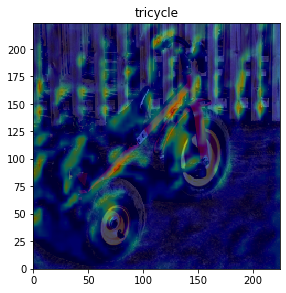

In [31]:
# iterate through each image and visually identify photos that the model predicts well
for image in IMG_PATH:

    # load in image
    img = load_image_as_array(image, size=(IMAGE_LENGTH, IMAGE_WIDTH))

    # create image tensor and preprocess image for prediction
    img_tensor = np.expand_dims(img, axis=0)
    img_tensor = preprocess_input(img_tensor)

    # predict image
    preds = model.predict(img_tensor)
    
    # extract labels
    labels = [label[1] for label in decode_predictions(preds, top=3)[0]]
    print(labels)

    # getting a list of predicted classes
    predicted_class = np.argmax(preds)

    # extract top 3 indices
    preds = np.squeeze(preds)
    topk_idx = np.argsort(preds)[-1:]

    # get class areas for each of top k predictions
    all_S = [grad_cam_single_filter(img, class_idx=idx) for idx in topk_idx]

    # show each heatmap
    plt.figure(figsize=(15,5))
    for i,idx in enumerate(topk_idx):    
        plt.subplot(1,3,i+1)
        plt.imshow(np.squeeze(all_S[i]))
        plt.title(labels[i])
        
    # show overlay of each heatmap
    plt.figure(figsize=(15,5),frameon=False)
    for i,idx in enumerate(topk_idx):    
        plt.subplot(1,3,i+1)
        
        plt.imshow(img/255, interpolation='nearest', extent=EXTENT)
        # use jet here for color mapping, even though I hate jet
        plt.imshow(np.squeeze(all_S[i]), cmap=plt.cm.jet, alpha=0.4,
                interpolation='bilinear',
                extent=EXTENT)
        
        plt.title(labels[i])
        
    plt.show()

Once again we are using heatmaps to show where on our test images the filter is being maximally excited. These heatmaps support our hypothsesis that the filter is activating on diagonal lines going upwards from left to right, with the excpetion of the photocopier. The best example of support for our hypothesis is the tricycle. The frame of the tricycle in this image is a diagonal line going upwards from left to right, and that is exactly what the filter is activating most on. In the school bus image, the filter is activating on the lines on the bus, as will as the outlines of the trees in the backgrounds, both of which have slight diagonals going upwards from left to right. In the bell pepper image, the filter is activating on the edges of the peppers which are going diagonally upwards from left to right. The one place where the filter is very active in the finch image is the bird's wing, which again is diganoally upwards from left to right. 

The photocopier image, however, seems to activate the filter on vertical and horizontal lines. This heatmap does not support our hypothesis completely, but the filter is still activating on edge detection and lines.

>[4 Points] Analyze each channel of the multi-channel filter to this feature that might form a circuit. That is, visualize the convolutional filter (one channel) between the input activations and the current activation to understand which inputs make up a circuit. One method of doing this is given below:
>
>   - Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. 
>   - Keep the top six sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top six filters. 
>   - For these six strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?


In [32]:
conv_layer = model.get_layer(LAYER_NAME)
weights, biases = conv_layer.get_weights()
filter_coefficients = weights[:, :, FILTER_INDEX, :]

In [33]:
filter_coefficients = filter_coefficients.transpose((2, 0, 1))
filter_norms = [np.linalg.norm(f) for f in filter_coefficients]
sorted_filter_indices = np.argsort(filter_norms)[::-1]
top_six_indices = sorted_filter_indices[:6]
top_six_input_filters = [filter_coefficients[i,:,:] for i in top_six_indices]

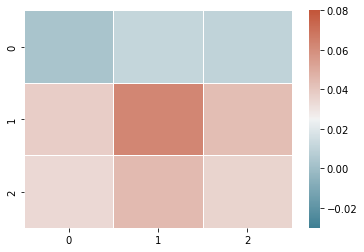

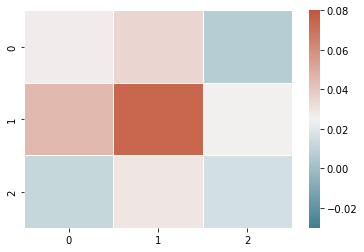

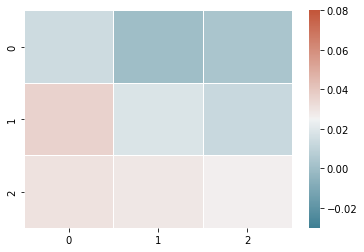

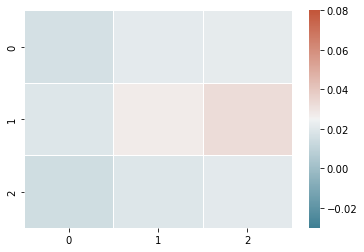

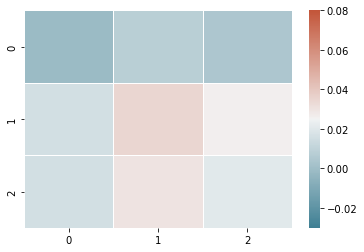

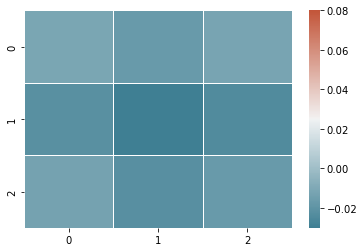

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

pallette = sns.diverging_palette(220, 20, as_cmap=True)

for filter in top_six_input_filters:
    ax = sns.heatmap(filter, linewidth=0.5, vmin=-0.03, vmax=0.08, cmap=pallette)
    plt.show()

In these heatmaps, red corresponds to excitatory, and blue corresponds to inhibitory. Based on this, we can see that filters 1 and 2 are mostly excitatory, filter 3 is split between the excitatory and inhibitory, filters 4 and 5 are mostly inhibitory, and filter 6 is completely inhibitory.

>[4 Points] For each of the six chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by (that is, what image maximally excites each of these filters?). This is a similar analysis to the first step, but now isolating the filters directly before your chosen filter. 

>   - Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here: https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.html 
>   - Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/ (such as determining if this is polysemantic, pose-invariant, etc.)  
>   - Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why? 

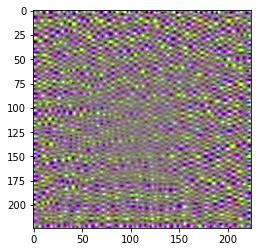

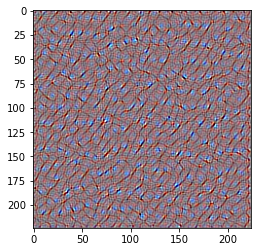

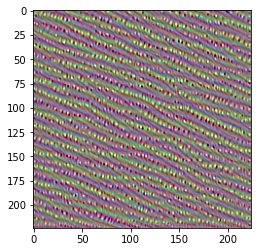

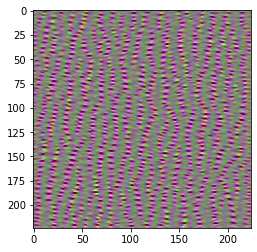

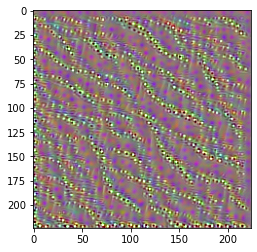

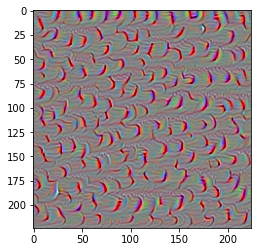

In [35]:
for x in range(6):
    excited_image = generate_pattern("block3_conv2",top_six_indices[x], size=IMAGE_LENGTH)
    excited_image = prepare_image_for_display(excited_image, norm_type='std')
    plt.imshow(excited_image)
    plt.show()

These filters seem to be looking for textured patterns??? Not really looking for diagonal lines like we thought. "This is a broad, not very well defined category for units that seem to look for simple local structures over a wide receptive field, including mixtures of colors. Many live in a branch consisting of a maxpool followed by a 1x1 conv, which structurally encourages this. 8" from the zoom in article. From looking at the rest of the categories listed in the article, this seems to be the one that fits the best. Honestly its hard to say. These 6 don't have anything striking in common. Thoughts?

## Final Analysis